In [1]:
import evaluate
import features
import matplotlib.pyplot as plt
import numpy as np
import test_train_sets
import time
import torch
import torch.nn as nn
import torch.optim as optim
import shap
from torch.autograd import Variable


# Packages the hyperparameters to the problem in one class.
# The MLP model will have as many hidden layers as specified by the length of hidden_layer_sizes
# hyperparameter, and each hidden layer will the corresponding size.
class MLPHyperParameters:
    def __init__(
        self,
        k,
        use_prosodic,
        use_other_features,
        summarize_bert_features,
        learning_rate,
        num_epochs,
        hidden_layer_sizes,
        dropout_probability,
    ):
        self.k = k
        self.use_prosodic = use_prosodic
        self.use_other_features = use_other_features
        self.summarize_bert_features = summarize_bert_features
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_probability = dropout_probability
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs


# Does one full iteration of training over the data in training_data_loader, updating
# the model using the given optimizer and loss_function.
def train_one_epoch(training_data_loader, model, optimizer, loss_function):
    model.train()
    all_losses = np.array([])
    for features, labels in training_data_loader:
        optimizer.zero_grad()
        predictions = model(features)
        # print("Predictions: ", predictions)
        # print("Labels: ", labels)
        loss = loss_function(predictions, labels)
        all_losses = np.append(all_losses, loss.item())
        loss.backward()
        optimizer.step()
    return np.mean(all_losses)


# Computes the mean loss with respect to the given loss function over the data in the
# given data loader. The `flatten` parameter is used to control the shape of the
# inputs and outputs.
def mean_validation_loss(validation_data_loader, model, loss_function):
    model.eval()
    all_validation_losses = np.array([])
    for validation_samples, validation_labels in validation_data_loader:
        predictions = model(validation_samples)
        loss = loss_function(predictions, validation_labels).item()
        all_validation_losses = np.append(all_validation_losses, loss)
    return np.mean(all_validation_losses)


# Plots the learning curve (validation loss over epochs).
def plot_losses(train_losses_by_epoch, validation_losses_by_epoch):
    plt.scatter(
        range(len(train_losses_by_epoch)),
        train_losses_by_epoch,
        s=9,
        label="Training loss (dropout applied)",
    )
    plt.scatter(
        range(len(validation_losses_by_epoch)),
        validation_losses_by_epoch,
        s=9,
        label="Validation loss (no dropout)",
    )
    plt.xlabel("Training epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()


# Trains the given model against the given data, with given hyperparameters, evaluating
# against the given validation data. Returns a list of losses against both the training
# data and validation data.
def train_and_report(
    model,
    training_data_loader,
    validation_data_loader,
    num_epochs,
    learning_rate,
):
    train_losses_by_epoch = []
    validation_losses_by_epoch = []
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=0
    )
    loss_function = nn.MSELoss()
    start_time = time.time()
    for epoch in range(num_epochs):
        train_losses_by_epoch.append(
            train_one_epoch(training_data_loader, model, optimizer, loss_function)
        )
        validation_losses_by_epoch.append(
            mean_validation_loss(validation_data_loader, model, loss_function)
        )
        if epoch % 10 == 9:
            print("Trained to epoch: ", epoch)
    end_time = time.time()
    print("Time to train (sec): ", end_time - start_time)
    print("Latest training loss: ", train_losses_by_epoch[-1])
    print("Latest validation loss: ", validation_losses_by_epoch[-1])
    return train_losses_by_epoch, validation_losses_by_epoch


# A feedforward net with leaky ReLU activations. If `dropout` is true, then dropout layers will be added between
# all intermediate layers.
def ff_leaky_relu_model(hidden_layer_sizes, input_size, dropout_probability):
    args = [nn.Linear(input_size, hidden_layer_sizes[0]), nn.LeakyReLU()]
    if dropout_probability > 0:
        args.append(nn.Dropout(dropout_probability))
    for i in range(len(hidden_layer_sizes) - 1):
        args += [
            nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]),
            nn.LeakyReLU(),
        ]
        if dropout_probability > 0:
            args.append(nn.Dropout(dropout_probability))
    args.append(nn.Linear(hidden_layer_sizes[-1], 2))
    return nn.Sequential(*args)


# For the given hyperparameters, runs cross-validation and plots an averaged learning curve
# across all validation runs.
def evaluate_with_hyperparameters(hps: MLPHyperParameters):
    training_losses = []
    validation_losses = []
    for validation_index in [0, 1, 2, 3]:
        validation_participants = test_train_sets.get_train_set(validation_index)
        training_participants = [
            participant
            for participant_set in [
                test_train_sets.get_train_set(i)
                for i in [0, 1, 2, 3]
                if i != validation_index
            ]
            for participant in participant_set
        ]
        training_data_loader = torch.utils.data.DataLoader(
            features.dataset_for_participants(
                training_participants,
                hps.use_prosodic,
                hps.use_other_features,
                hps.summarize_bert_features,
                hps.k,
            )
        )
        validation_data_loader = torch.utils.data.DataLoader(
            features.dataset_for_participants(
                validation_participants,
                hps.use_prosodic,
                hps.use_other_features,
                hps.summarize_bert_features,
                hps.k,
            )
        )
        input_size = next(iter(training_data_loader))[0].shape[1]
        model = ff_leaky_relu_model(
            hps.hidden_layer_sizes, input_size, hps.dropout_probability
        )
        training_loss, validation_loss = train_and_report(
            model,
            training_data_loader,
            validation_data_loader,
            hps.num_epochs,
            hps.learning_rate,
        )
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)

    plot_losses(
        np.mean(np.vstack(training_losses), axis=0),
        np.mean(np.vstack(validation_losses), axis=0),
    )
    return np.mean(np.mean(np.vstack(validation_losses), axis=0)[-5:])


# The start of hyperparameter optimzation. Reasonable guesses for everything; we'll start
# by tuning the learning rate.
def initial_hps_guess_with_learning_rate(learning_rate):
    return MLPHyperParameters(
        k=17,
        summarize_bert_features=True,
        learning_rate=learning_rate,
        num_epochs=30,
        hidden_layer_sizes=[2048, 256, 32],
        dropout_probability=0.1,
    )


# Searches for the best learning rate.
def compare_learning_rates():
    rates_to_compare = [1e-5, 3e-5, 5e-5, 1e-4]
    losses = [
        evaluate_with_hyperparameters(
            initial_hps_guess_with_learning_rate(learning_rate)
        )
        for learning_rate in rates_to_compare
    ]
    best_loss_idx = np.argmin(losses)
    return rates_to_compare[best_loss_idx], losses[best_loss_idx]


# compare_learning_rates()
# Best appears to be 3e-5.


# The start of hyperparameter optimzation. Reasonable guesses for everything; we'll start
# by tuning the learning rate.
def hps_guess_1_with_summarize_bert(summarize_bert):
    return MLPHyperParameters(
        k=17,
        summarize_bert_features=summarize_bert,
        learning_rate=3e-5,
        num_epochs=30,
        hidden_layer_sizes=[2048, 256, 32],
        dropout_probability=0.1,
    )


def compare_bert_summarization():
    values_to_compare = [False, True]
    losses = [
        evaluate_with_hyperparameters(hps_guess_1_with_summarize_bert(value))
        for value in values_to_compare
    ]
    best_loss_idx = np.argmin(losses)
    return values_to_compare[best_loss_idx], losses[best_loss_idx]


# Summarizing / aggregating works better


def hps_guess_2_with_hidden_layers(hidden_layers):
    return MLPHyperParameters(
        k=17,
        summarize_bert_features=True,
        learning_rate=3e-5,
        num_epochs=30,
        hidden_layer_sizes=hidden_layers,
        dropout_probability=0.1,
    )


def compare_hidden_layers():
    values_to_compare = [
        [4096, 512, 32],
    ]
    losses = [
        evaluate_with_hyperparameters(hps_guess_2_with_hidden_layers(value))
        for value in values_to_compare
    ]
    best_loss_idx = np.argmin(losses)
    return values_to_compare[best_loss_idx], losses[best_loss_idx]


# Best so far: [4096, 512, 32]


def hps_guess_3_with_dropout_probability(dropout_probability):
    return MLPHyperParameters(
        k=17,
        summarize_bert_features=True,
        learning_rate=3e-5,
        num_epochs=50,
        hidden_layer_sizes=[4096, 512, 32],
        dropout_probability=dropout_probability,
    )


def compare_dropout_probabilities():
    values_to_compare = [0.05, 0.1, 0.2, 0.3]
    losses = [
        evaluate_with_hyperparameters(hps_guess_3_with_dropout_probability(value))
        for value in values_to_compare
    ]
    best_loss_idx = np.argmin(losses)
    return values_to_compare[best_loss_idx], losses[best_loss_idx]


def hps_guess_4_with_epochs(num_epochs):
    return MLPHyperParameters(
        k=17,
        summarize_bert_features=True,
        learning_rate=3e-5,
        num_epochs=num_epochs,
        hidden_layer_sizes=[4096, 512, 32],
        dropout_probability=0.2,
    )


def compare_epochs():
    values_to_compare = [50, 100, 150, 200]
    losses = [
        evaluate_with_hyperparameters(hps_guess_4_with_epochs(value))
        for value in values_to_compare
    ]
    best_loss_idx = np.argmin(losses)
    return (
        values_to_compare[best_loss_idx],
        losses[best_loss_idx],
        values_to_compare,
        losses,
    )


def tuned_hps(k, use_prosodic, use_other_features):
    return MLPHyperParameters(
        k=k,
        use_prosodic=use_prosodic,
        use_other_features=use_other_features,
        summarize_bert_features=True,
        learning_rate=3e-5,
        num_epochs=100,
        hidden_layer_sizes=[4096, 512, 32],
        dropout_probability=0.2,
    )


def train_and_infer_against_test_set(hps):
    test_participants = test_train_sets.get_test_set()
    training_participants = [
        participant
        for participant_set in [
            test_train_sets.get_train_set(i)
            for i in [0, 1, 2, 3]
        ]
        for participant in participant_set
    ]

    training_data_loader = torch.utils.data.DataLoader(
        features.dataset_for_participants(
            training_participants,
            hps.use_prosodic,
            hps.use_other_features,
            hps.summarize_bert_features,
            hps.k,
        )
    )
    test_data_loader = torch.utils.data.DataLoader(
        features.dataset_for_participants(
            test_participants,
            hps.use_prosodic,
            hps.use_other_features,
            hps.summarize_bert_features,
            hps.k,
        )
    )
    input_size = next(iter(training_data_loader))[0].shape[1]
    model = ff_leaky_relu_model(
        hps.hidden_layer_sizes, input_size, hps.dropout_probability
    )
    _, _ = train_and_report(
        model,
        training_data_loader,
        test_data_loader,
        hps.num_epochs,
        hps.learning_rate,
    )
    model.eval()
    labels_and_predictions = []
    all_train_samples = []
    all_train_labels = []
    for test_samples, test_labels in test_data_loader:
        predictions = model(test_samples)
        labels_and_predictions.append((test_labels, predictions))
        # evaluate.evaluate(test_labels, predictions)
    for train_samples, train_labels in training_data_loader:
        all_train_samples.append(train_samples)
        all_train_labels.append(train_labels)

    return model, labels_and_predictions


def evaluate_test_inference(labels_and_preds):
    labels = [combined[0] for combined in labels_and_preds]
    preds = [combined[1] for combined in labels_and_preds]
    overall_labels = [label.numpy()[0][0] for label in labels]
    excitement_labels = [label.numpy()[0][1] for label in labels]
    overall_preds = [pred[0].detach().numpy()[0] for pred in preds]
    excitement_preds = [pred[0].detach().numpy()[1] for pred in preds]
    print("MLP overall evaluation: ")
    overall = evaluate.evaluate(np.array(overall_preds), np.array(overall_labels))
    print("MLP excitement evaluation: ")
    excitement = evaluate.evaluate(
        np.array(excitement_preds), np.array(excitement_labels)
    )
    return (overall, excitement)

In [9]:
model, labels_and_predictions = train_and_infer_against_test_set(tuned_hps(17,True,True))

Trained to epoch:  9
Trained to epoch:  19
Trained to epoch:  29
Trained to epoch:  39
Trained to epoch:  49
Trained to epoch:  59
Trained to epoch:  69
Trained to epoch:  79
Trained to epoch:  89
Trained to epoch:  99
Time to train (sec):  307.07197999954224
Latest training loss:  1.1495462750856489
Latest validation loss:  0.5294522640489352


In [113]:
hps = tuned_hps(17,True,True)

training_participants = [
    participant
    for participant_set in [
        test_train_sets.get_train_set(i)
        for i in [0, 1, 2, 3]
    ]
    for participant in participant_set
]

training_data_loader = torch.utils.data.DataLoader(
    features.dataset_for_participants(
        training_participants,
        hps.use_prosodic,
        hps.use_other_features,
        hps.summarize_bert_features,
        hps.k,
    )
)
all_train_samples = []
all_train_labels = []
for train_samples, train_labels in training_data_loader:
    all_train_samples.append(train_samples.detach().numpy()[0])
    all_train_labels.append(train_labels.detach().numpy()[0])

data = np.array(all_train_samples)

# Define function to wrap model to transform data to tensor
f = lambda x: model(Variable(torch.from_numpy(x))).detach().numpy()

# Convert my pandas dataframe to numpy
# data = all_train_samples[0].detach().numpy()
# The explainer doesn't like tensors, hence the f function
feature_names_bert = ['']*256
for index, feature_name in enumerate(feature_names_bert):
    feature_names_bert[index] = 'bert_' + str(index)
feature_names_sentiment = ['interviewee_pos', 'interviewer_pos', 'interviewer_compound', 'overall_neu', 'interviewee_neg', 'interviewee_neu', 'interviewer_neg', 'interviewer_neu', 'interviewee_compound', 'other_neg', 'overall_compound', 'overall_neg', 'overall_pos', 'other_neu', 'other_pos', 'other_compound']
feature_names_prosodic = ['voice_steadiness', 'average_pause_length', 'pause_frequency', 'falling_intonation', 'speech_volume', 'volume_steadiness', 'volume_range', 'speaking_pace', 'voice_break_frequency', 'pitch_range', 'rising_intonation', 'average_response_length', 'pitch_expressiveness', 'average_pitch', 'volume_variability', 'longest_pause']
feature_names = feature_names_bert + feature_names_sentiment + feature_names_prosodic

explainer = shap.KernelExplainer(model=f, data=data[:50], feature_names=feature_names)
shap_values = explainer(data[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

pp45


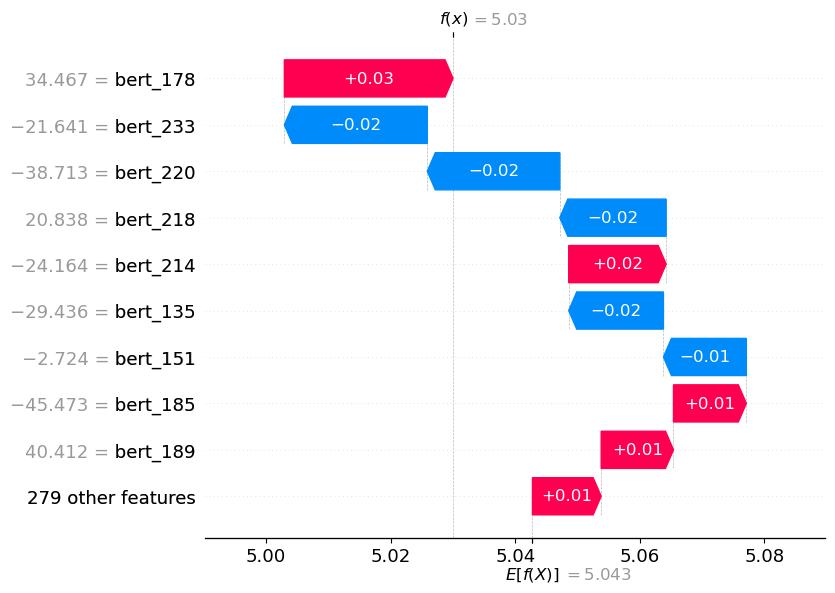

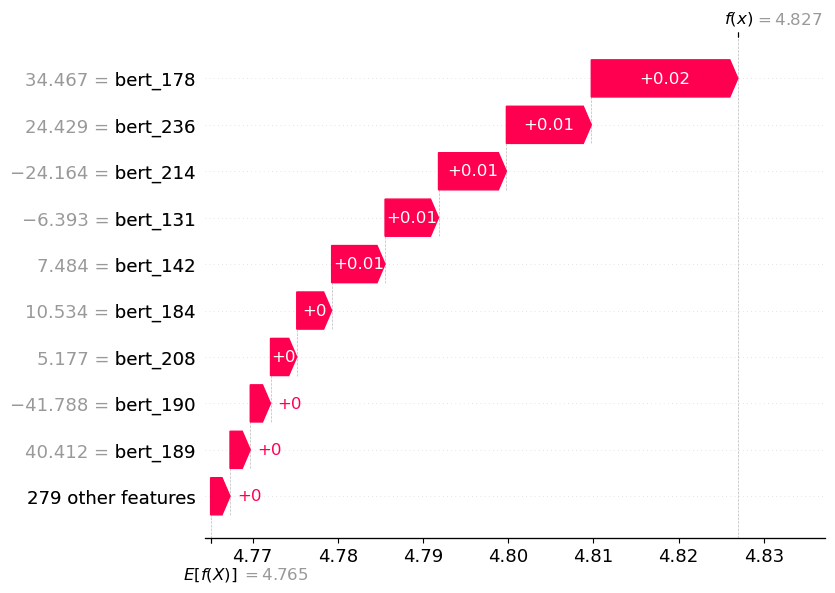

In [162]:
num = 5
print(training_participants[num])
shap.waterfall_plot(shap_values[num,:,0], max_display=10)
shap.waterfall_plot(shap_values[num,:,1], max_display=10)

In [134]:
print(labels_and_predictions)

[(tensor([[5.2973, 5.0439]]), tensor([[5.0452, 4.8246]], grad_fn=<AddmmBackward0>)), (tensor([[4.4149, 5.6016]]), tensor([[5.0717, 4.8340]], grad_fn=<AddmmBackward0>)), (tensor([[5.7993, 4.8860]]), tensor([[5.1259, 4.8664]], grad_fn=<AddmmBackward0>)), (tensor([[4.7251, 4.3839]]), tensor([[5.0682, 4.8236]], grad_fn=<AddmmBackward0>)), (tensor([[5.2326, 5.3465]]), tensor([[5.0292, 4.8327]], grad_fn=<AddmmBackward0>)), (tensor([[3.8622, 3.1715]]), tensor([[5.0917, 4.7638]], grad_fn=<AddmmBackward0>)), (tensor([[4.4387, 3.7909]]), tensor([[4.9878, 4.7657]], grad_fn=<AddmmBackward0>)), (tensor([[5.1846, 5.4336]]), tensor([[5.0099, 4.7924]], grad_fn=<AddmmBackward0>)), (tensor([[3.9912, 3.4841]]), tensor([[5.0567, 4.7442]], grad_fn=<AddmmBackward0>)), (tensor([[5.0831, 3.9094]]), tensor([[5.1273, 4.8398]], grad_fn=<AddmmBackward0>)), (tensor([[5.8460, 6.0724]]), tensor([[5.0944, 4.7353]], grad_fn=<AddmmBackward0>)), (tensor([[4.7371, 3.8534]]), tensor([[5.3130, 4.7786]], grad_fn=<AddmmBackw

In [136]:

evaluate_test_inference(labels_and_predictions)

MLP overall evaluation: 
Mean Absolute Relative Error: 0.0909
Pearson: 0.1379 (p-value: 0.4675)
MLP excitement evaluation: 
Mean Absolute Relative Error: 0.1418
Pearson: 0.1422 (p-value: 0.4536)


((0.09094432, 0.1378698114892691), (0.14177589, 0.14217950422346712))

In [160]:
print(f(data[5]))
labels = np.array(all_train_labels)
print(labels[5])

[5.0300193 4.826942 ]
[5.038526 5.322526]


In [152]:
thing = features.dataset_for_participants(
        training_participants,
        hps.use_prosodic,
        hps.use_other_features,
        hps.summarize_bert_features,
        hps.k,
    )
print(thing)